
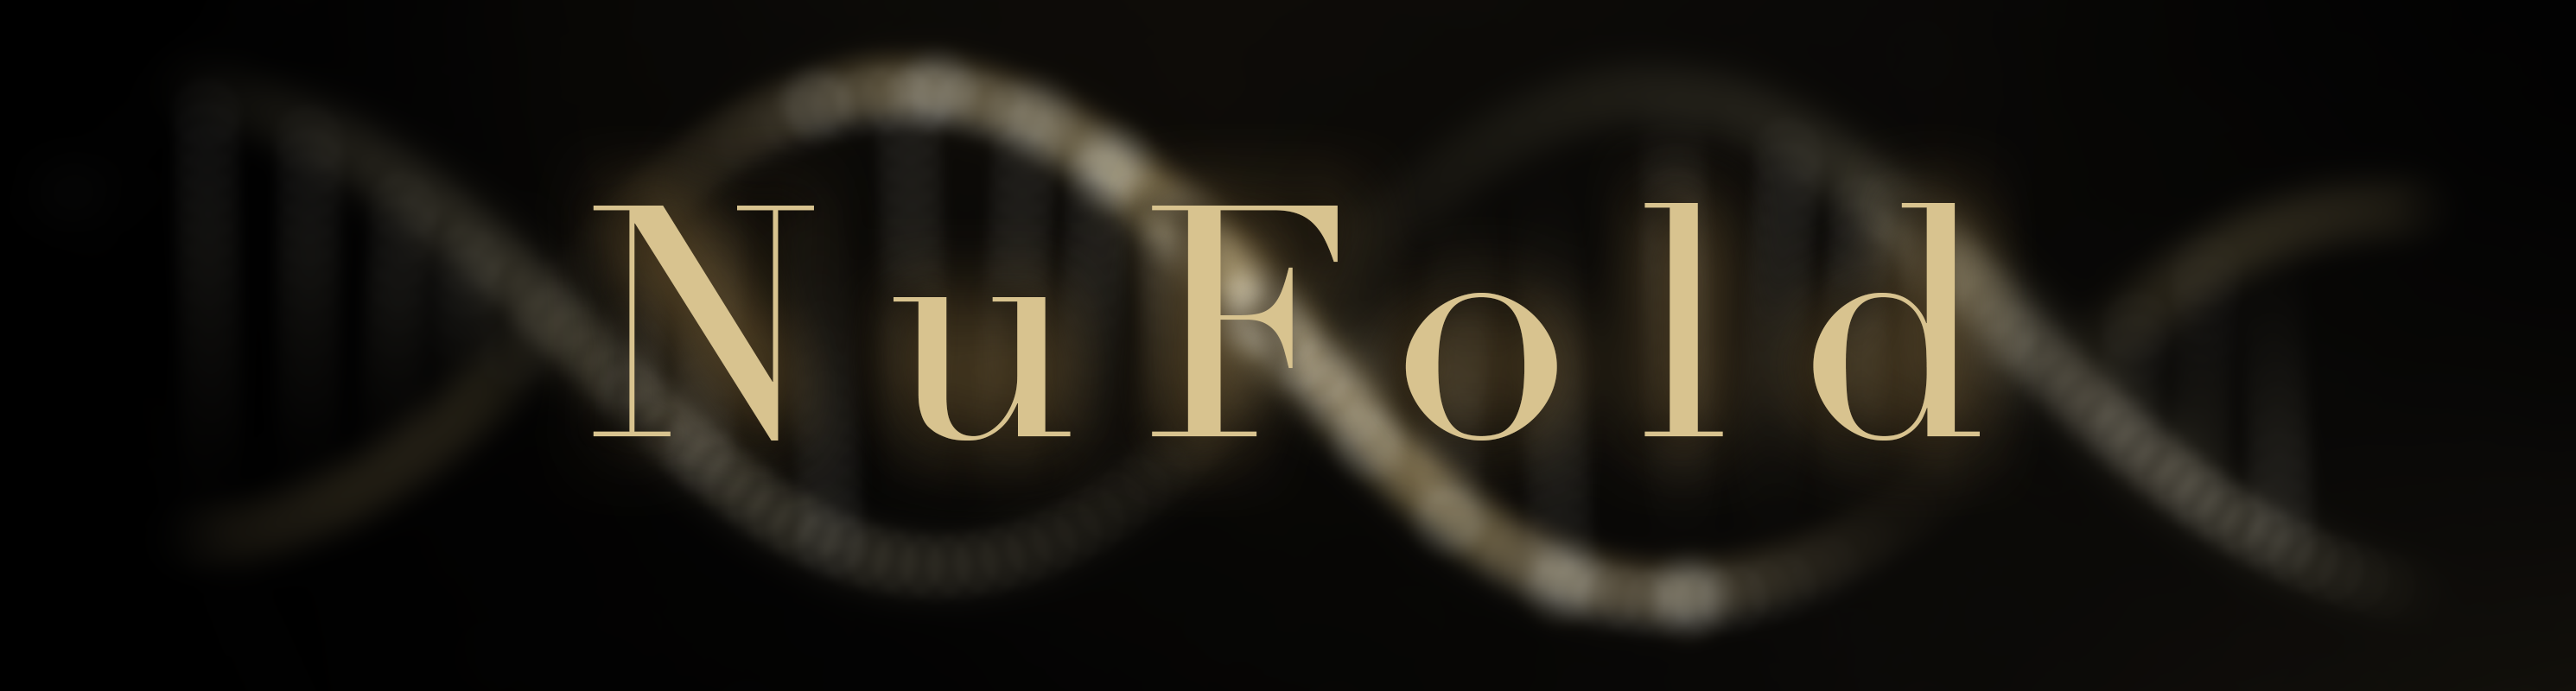</center>

# HOW TO USE NUFOLD
- Below you will find a place to input your sequence and job name.
- After giving sequence, go to the toolbar above, click `Runtime` and then `Run all`.
- Change any settings you want to change before running.

In [1]:
#@title Input your RNA sequence and provide a job name (optional)
#@markdown # Add your data here
import random
import string
import os

def random_string(length=10):
    """Generate a random string of fixed length."""
    letters = string.ascii_lowercase
    return ''.join(random.choice(letters) for i in range(length))

rna_sequence = "GCCCGGAUGAUCCUCAGUGGUCUGGGGUGCA"  # @param {type: "string"}
length = len(rna_sequence)
print(f"RNA sequence length: {length}")
rna_sequence = rna_sequence.upper()
job_name = 'tRNA'  # @param {type: "string"}

if not job_name:
    job_name = random_string()

# Prepare the FASTA content
fasta_content = f">{job_name}\n{rna_sequence}"
jobs_dir = "jobs"
if not os.path.exists(jobs_dir):
    os.makedirs(jobs_dir)
job_base_dir = os.path.join(jobs_dir, f"{job_name}_base")
if not os.path.exists(job_base_dir):
    os.makedirs(job_base_dir)
actual_job_dir = os.path.join(job_base_dir, job_name)
if not os.path.exists(actual_job_dir):
    os.makedirs(actual_job_dir)
fasta_filename = f"{job_name}.fasta"
fasta_filepath = os.path.join(actual_job_dir, fasta_filename)
with open(fasta_filepath, "w") as fasta_file:
    fasta_file.write(fasta_content)

print(f"RNA sequence saved as {fasta_filepath} of length: {length}")

#@markdown If you want to download NuFold's output to your computer automatically, you can check this box here. Otherwise after the run is complete you can go to `/nufold_output` on the file explorer on the left side and download the folder with your job name.
download = True #@param {type:"boolean"}

#@markdown Additional Settings:
num_recycles = 5 # @param {type:"number"}
msa_speed = 2 # @param {type:"slider", min:0, max:2, step:1}
#@markdown - 0 for slowest, 1 for normal, 2 for fast (Faster = Lower Quality)



RNA sequence length: 31
RNA sequence saved as jobs/tRNA_base/tRNA/tRNA.fasta of length: 31


In [ ]:
#@title Installing Dependencies (This is going to take a approximately 5 minutes when you run this notebook the first time)
import os
import subprocess

!rm -rf sample_data

def run_command(command, log_file, message=None):
    with open(log_file, 'a') as file:
        subprocess.run(command, shell=True, stdout=file, stderr=subprocess.STDOUT)
    if message:
        print(message)

logs_file = 'logs.txt'
open(logs_file, 'w').close()

# Install libraries
run_command(
    "pip install ml-collections dm-tree deepspeed protobuf scipy biopython py3dmol",
    logs_file,
    "Libraries installation complete."
)

# Check and Install ipknot if not exists
if not os.path.exists('/content/ipknot'):
    run_command(
        "wget https://github.com/satoken/ipknot/releases/download/v1.1.0/ipknot-1.1.0-x86_64-linux.zip && "
        "unzip ipknot-1.1.0-x86_64-linux.zip && "
        "rm ipknot-1.1.0-x86_64-linux/README.md && "
        "mv ipknot-1.1.0-x86_64-linux/ipknot /content && "
        "rmdir ipknot-1.1.0-x86_64-linux && "
        "rm ipknot-1.1.0-x86_64-linux.zip && "
        "chmod +x /content/ipknot",
        logs_file,
        "ipknot installation complete."
    )
else:
    print("ipknot already exists. Skipping installation.")

# Check and Install rMSA if not exists
if not os.path.exists('rMSA'):
    run_command(
        "apt-get install aria2 && "
        "git clone https://github.com/pylelab/rMSA && "
        "cd rMSA/database/ && "
        "aria2c -q -R -x 16 -j 20 -s 65536 -c --optimize-concurrent-downloads https://kiharalab.org/nufold/database.zip && "
        "unzip database.zip && "
        "rm database.zip && "
        "cd ../../",
        logs_file,
        "rMSA installation complete."
    )
else:
    print("rMSA directory already exists. Skipping installation.")

# Check and Setup NuFold if not exists
# Make sure to add gitclone nufold here.
if not os.path.exists('/content/run_nufold.py'):
    run_command(
        "git clone https://github.com/kiharalab/NuFold &&"
        "mv /content/NuFold/nufold /content && "
        "mv /content/NuFold/run_nufold.py /content && "
        "rm -rf /content/NuFold",
        logs_file,
        "NuFold setup complete."
    )
else:
    print("NuFold is already set up. Skipping installation.")

print("All installations and setups are complete. Check logs.txt for details.")


Libraries installation complete.
ipknot installation complete.


In [ ]:
#@title Data Preprocess: Compute pseudoknots and perform MSA
#@markdown This step is going to take a while, allow some time for this step (keep the page open)

# Paths
jobs_dir = "jobs"
job_dir = os.path.join(jobs_dir, job_name)
fasta_filepath = os.path.join(job_dir, fasta_filename)
ss_output_path = os.path.join(job_dir, f"{job_name}.ss")

# Change to the job directory
%cd {actual_job_dir}
# Run ipknot and capture output
!../../../ipknot {fasta_filename} > {fasta_filename.replace('.fasta', '')}.ipknot.ss
print("ipknot output saved")

%cd ../../..
# Run rMSA.pl
seqpath = os.path.join(actual_job_dir, fasta_filename)
!sed -i 's@$dbdir/nt@@g' rMSA/rMSA.pl
!rMSA/rMSA.pl {seqpath} -cpu=2 -fast={msa_speed}
print("rMSA.pl run completed.")

In [ ]:
#@title Now we're going to setup and actually do the NuFold part

# #@markdown Hang in there we're almost done


if not os.path.exists('checkpoints'):
    os.makedirs('checkpoints')
    !wget -O checkpoints/global_step145245.pt http://kiharalab.org/nufold/global_step145245.pt
else:
    print('"checkpoints" already fetched')


seq = os.path.join(actual_job_dir, fasta_filename)
!mkdir nufold_output
!python /content/run_nufold.py \
  --ckpt_path /content/checkpoints/global_step145245.pt \
  --input_fasta {seq} \
  --input_dir {job_base_dir}\
  --output_dir /content/nufold_output \
  --config_preset initial_training \
  --recycle {num_recycles}


In [ ]:
#@title Display Result
import os
import py3Dmol
from IPython.display import display, Markdown
from google.colab import files as colabdl
import shutil

# Assuming output_path and fasta_filename are defined as shown previously
output_path = os.path.join("/content/nufold_output", fasta_filename.replace(".fasta", ''))
files = os.listdir(output_path)
# Filter for the PDB file with the specific prefix "_unrelaxed0.pdb"
pdb_files = [x for x in files if x.startswith(job_name) and x.endswith(".pdb")]

# Function to visualize PDB file with py3Dmol
def visualize_pdb_file(pdb_file_path):
    with open(pdb_file_path) as ifile:
        system = "".join([x for x in ifile])
    view = py3Dmol.view(width=400, height=300)  # Adjust size as needed
    view.addModelsAsFrames(system)
    view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':50,'max':90}}})# Apply styling
    view.zoomTo()
    return view

# If there's at least one file that matches the criteria, visualize it
if pdb_files:
    pdb_file = pdb_files[0]  # Assuming you only want the first match
    display(Markdown(f"# Your Result"))
    display(Markdown(f"## File Name: {pdb_file}"))
    view = visualize_pdb_file(os.path.join(output_path, pdb_file))
    view.show()
else:
    display(Markdown("No PDB file with the specified prefix found."))

# Code for downloading the ZIP file if needed
zipname = fasta_filename.replace(".fasta", '')
if download:
    zip_filename = f"{zipname}.zip"
    shutil.make_archive(zip_filename.replace('.zip', ''), 'zip', output_path)
    display(Markdown("## The download is probably going to take a while."))
    colabdl.download(zip_filename)  # This line will work in Google Colab to trigger the download
